In [1]:
import matplotlib.pyplot as plt
import ruptures as rpt
import os
import matplotlib as mpl
import numpy as np
import local_models.local_models
from gpr_utils import *

import logging
import ml_battery.log

logger = logging.getLogger(__name__)

In [16]:
signal_subsample_rate = 20
SIGNAL_HZ = 52
HZ=SIGNAL_HZ/signal_subsample_rate
CHANNEL_COLS=list(range(1,4))
CHANNELS = len(CHANNEL_COLS)
LABEL_COL = 4
RUN=19
gpr_subsample_rate=1
bandwidth = 160*HZ
n = int(2*bandwidth)-2
WHICH_DATA_FILE=5 # run7/5, run8/6, run9/5, run10/6, run11/6, run12/5, run13/6, run14/5

In [3]:
mpl.rcParams['figure.figsize'] = [16.0, 8.0]
mpl.rcParams['font.size'] = int(mpl.rcParams['figure.figsize'][1]*3)

In [4]:
data_dir = "/home/brown/disk2/USA/windowed_gaussian_process_study/data/chest_acc"
data_file_format = "{}.csv"
data_file = os.path.join(data_dir, data_file_format.format(str(WHICH_DATA_FILE)))

In [6]:
project_dir = "/home/brown/disk2/chest_acc/chest_acc_run{:03d}".format(RUN)
transformed_data_dir = os.path.join(project_dir, "transformed_data")
transformed_data_file_format = "f{:03d}_ax{:01d}.dat"

In [14]:
gpr_dat = np.stack([np.loadtxt(
    os.path.join(
        transformed_data_dir, 
        transformed_data_file_format.format(
            WHICH_DATA_FILE, ax))) for ax in range(1,4)
    ], axis=1)

In [22]:
gpr_dat.shape

(8001, 3)

In [15]:
dat = np.loadtxt(data_file,delimiter=",")

In [17]:
subsampled_dat = dat[::signal_subsample_rate]
X = np.arange(subsampled_dat.shape[0]).reshape(-1,1)
index = local_models.local_models.ConstantDistanceSortedIndex(X.flatten())
X_gpr_subsampled = X[::gpr_subsample_rate]
change_points = np.nonzero(np.diff(subsampled_dat[:,LABEL_COL]))[0]

In [18]:
subsampled_dat.shape

(8001, 5)

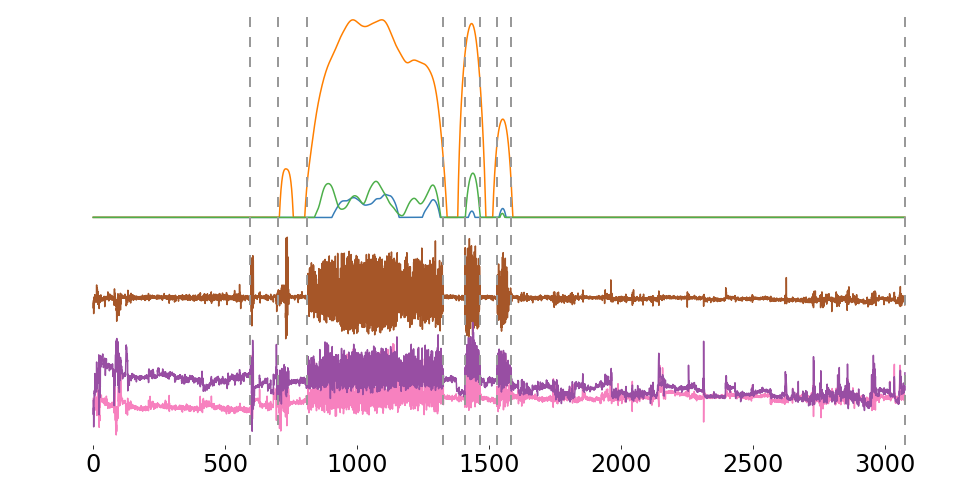

In [26]:
plt_gpr_params(X/HZ, subsampled_dat[:,1:4], X/HZ, gpr_dat, [change_points/HZ], display=True, legend=False)

In [27]:
def F_hat(y,u,continuity_correction=False):
    # the empirical cumulative distribution function
    return np.sum(y[:,None]<u,axis=0)/y.shape[0] - (1/(2*y.shape[0]))*continuity_correction
    
def c_F_hat(y,sorted_full_y):
    fhats = []
    for channel in range(y.shape[-1]):
        fhats.append(F_hat(y[:,channel],sorted_full_y[:,channel])[1:-1])
    fhats = np.stack(fhats).T
    n_times_n_minus_l = np.arange(2,sorted_full_y.shape[0])
    n_times_n_minus_l *= sorted_full_y.shape[0] + 1 - n_times_n_minus_l
    numer = np.sum(fhats*np.ma.log(fhats).filled(0)+(1-fhats)*np.ma.log(1-fhats).filled(0),axis=1)
    return y.shape[0]*np.sum(numer/n_times_n_minus_l)
    
from ruptures.base import BaseCost

class NonparametricDistributionCost(BaseCost):

    """Custom cost for exponential signals."""

    # The 2 following attributes must be specified for compatibility.
    model = "F_hat"
    min_size = 2

    def fit(self, signal):
        """Set the internal parameter."""
        self.signal = signal
        sorted_signal = []
        for channel in range(signal.shape[-1]):
            sorted_signal.append(np.sort(self.signal[...,channel]))
        self.sorted_signal = np.stack(sorted_signal).T
        self.previous_end = None
        self.timelog = local_models.local_models.loggin.TimeLogger(
            logger=logger, 
            how_often=1, total=self.signal.shape[0]/5, 
            tag="pelting")
        return self

    def error(self, start, end):
        """Return the approximation cost on the segment [start:end].

        Args:
            start (int): start of the segment
            end (int): end of the segment

        Returns:
            float: segment cost
        """
        if self.previous_end == None:
            self.previous_end = end
        if end != self.previous_end:
            with self.timelog:
                self.previous_end = end
        cost = -c_F_hat(self.signal[start:end], self.sorted_signal)
        return cost

In [28]:
c = NonparametricDistributionCost().fit(gpr_dat)

In [34]:
c.error(500,2900)

1.107842890847548

In [35]:
pens = 2.**np.arange(-10,4)

In [ ]:
from joblib import Parallel, delayed
results = Parallel(n_jobs=len(pens))(
    delayed(lambda pen: 
        rpt.Pelt(custom_cost=NonparametricDistributionCost()).fit(
            gpr_dat).predict(
                pen))(pen) 
    for pen in pens)

In [ ]:
results

In [42]:
project_dir = "/home/brown/disk2/chest_acc/pelt"
os.makedirs(project_dir, exist_ok=1)

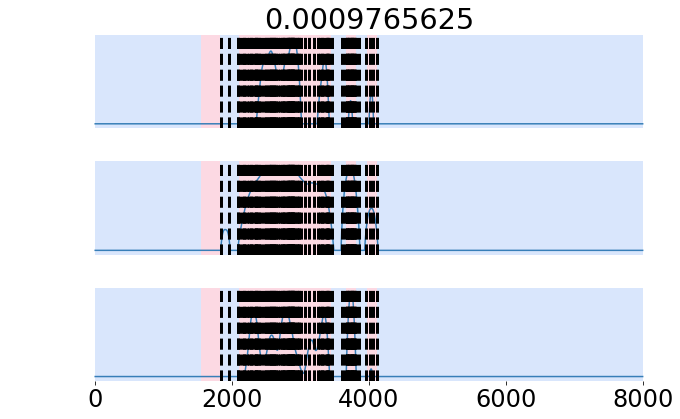

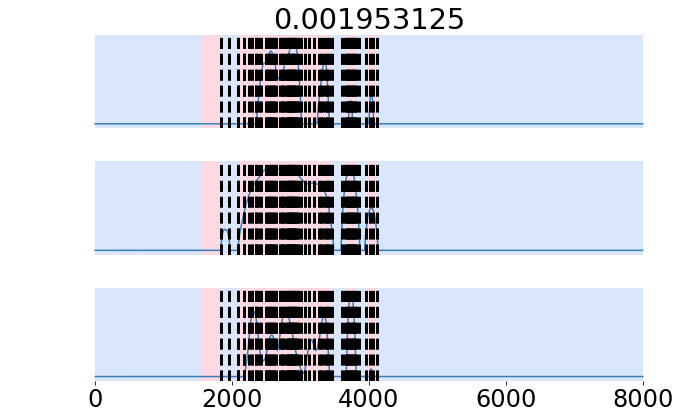

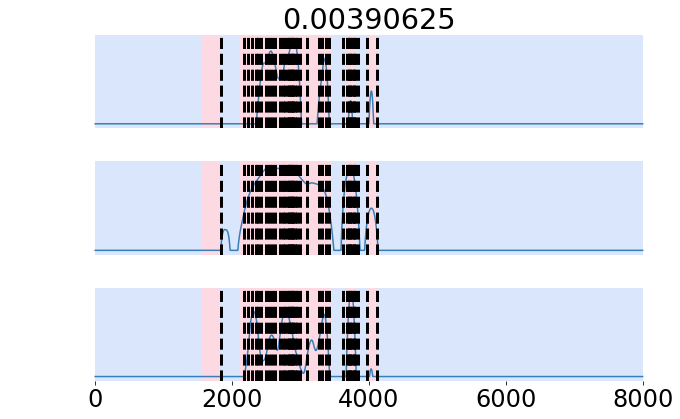

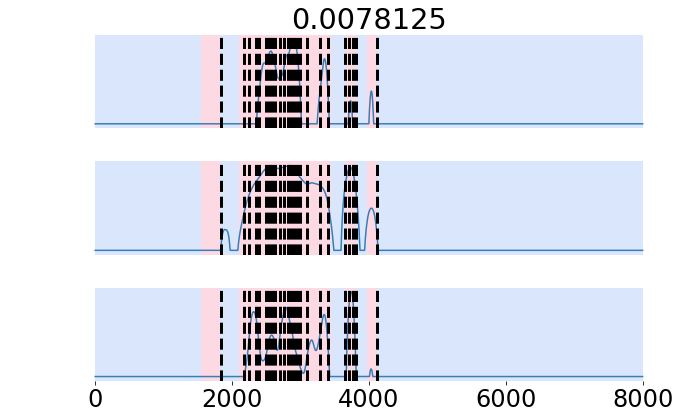

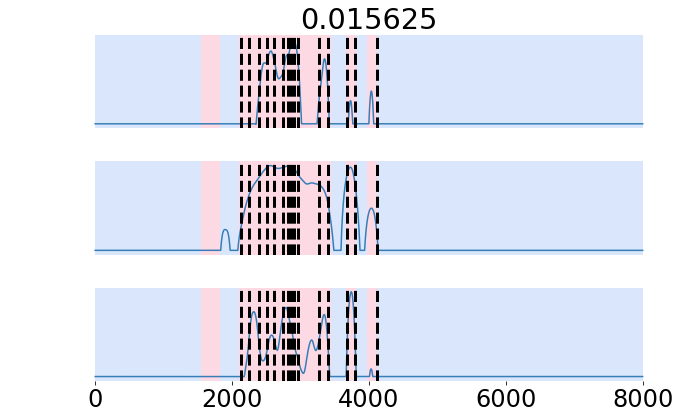

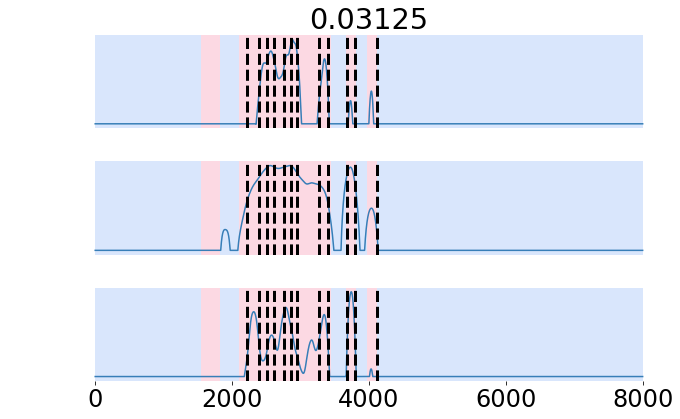

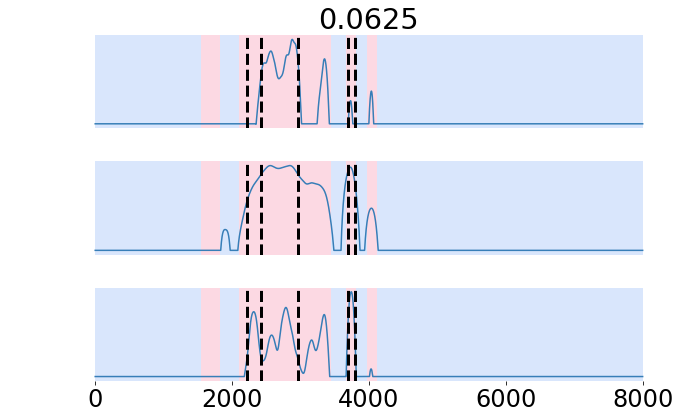

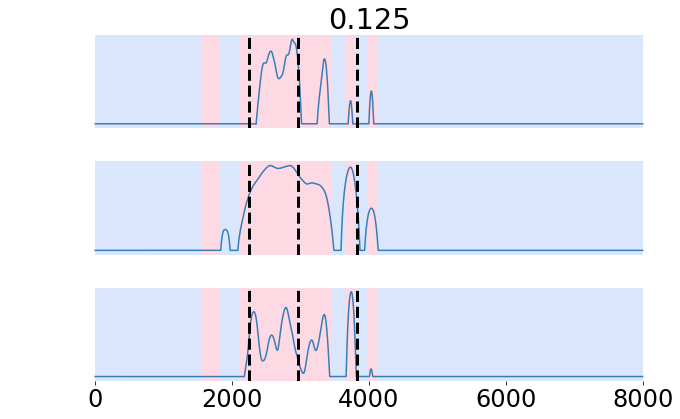

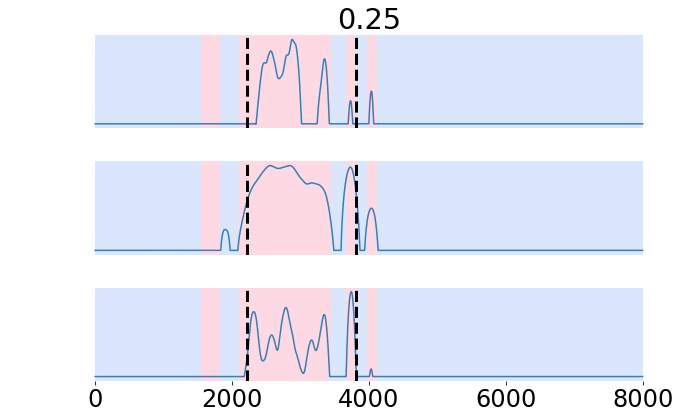

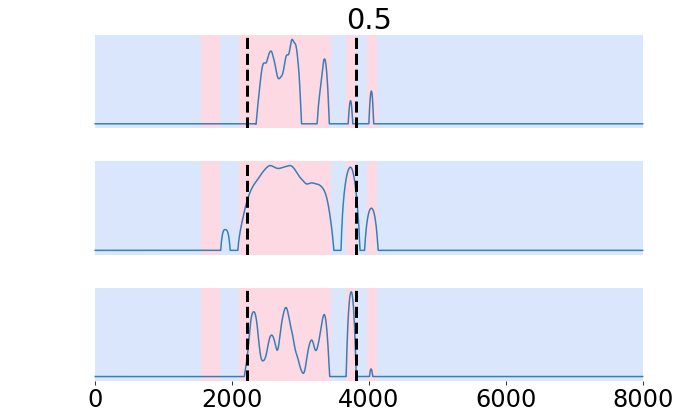

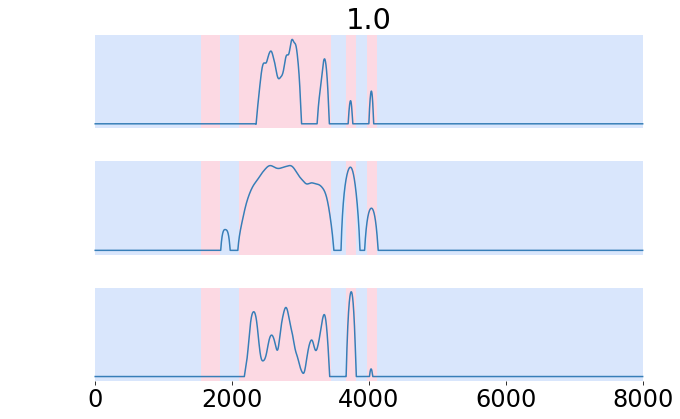

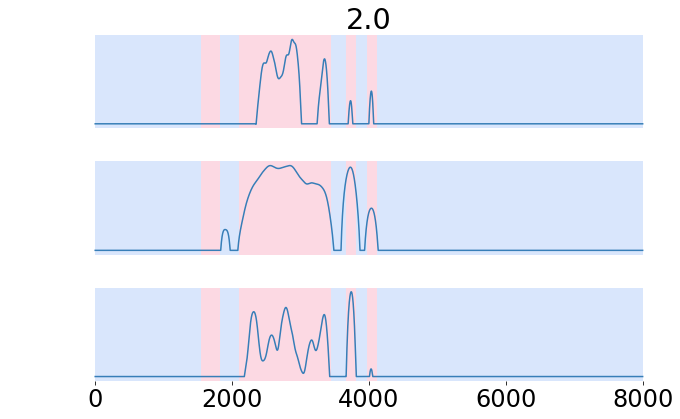

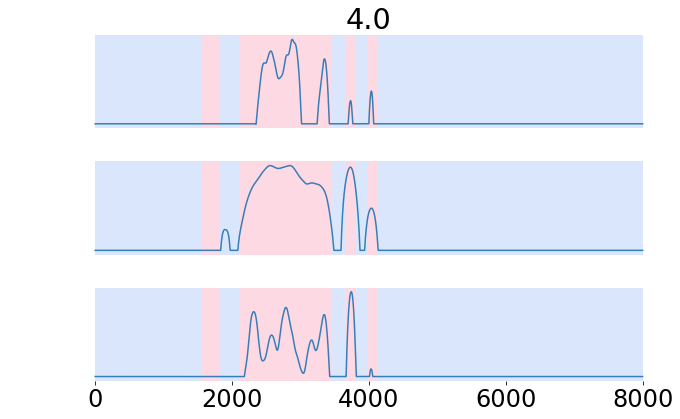

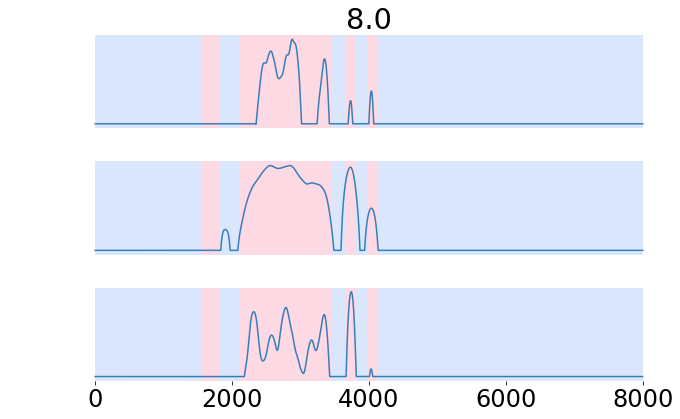

In [43]:
# display
for i,result in enumerate(results):
    fig, axs = rpt.display(gpr_dat, change_points, result)
    adjust_ax_labels(axs)
    axs[0].set_title(pens[i])
    plt.savefig(os.path.join(project_dir, "pelt_grid_search_gpr_features_{:02d}_p{:07.3f}.png".format(WHICH_DATA_FILE,pens[i]))) 




In [ ]:
# detection
algo = rpt.Pelt(custom_cost=NonparametricDistributionCost()).fit(subsampled_dat[:,1:-1])
result = algo.predict(pen=5)

In [ ]:
change_points

In [ ]:
result

In [ ]:
# display
rpt.display(subsampled_dat[1:], change_points, result)
plt.show()

In [61]:
# detection
gpr_algo = rpt.Pelt(model="rbf").fit(gpr_paramses[:,0,:])
gpr_result = gpr_algo.predict(pen=5)

In [ ]:
# display
rpt.display(gpr_paramses[:,0,:], change_points/gpr_subsample_rate, gpr_result)
plt.show()

In [63]:
catted = np.concatenate((gpr_paramses[:,0,:], subsampled_dat[::gpr_subsample_rate,1:-1]), axis=1)

In [67]:
gpr_subsample_rate

40

In [64]:
catted.shape

(201, 6)

In [65]:
# detection

cat_algo = rpt.Pelt(model="rbf").fit(catted)
cat_result = gpr_algo.predict(pen=2)


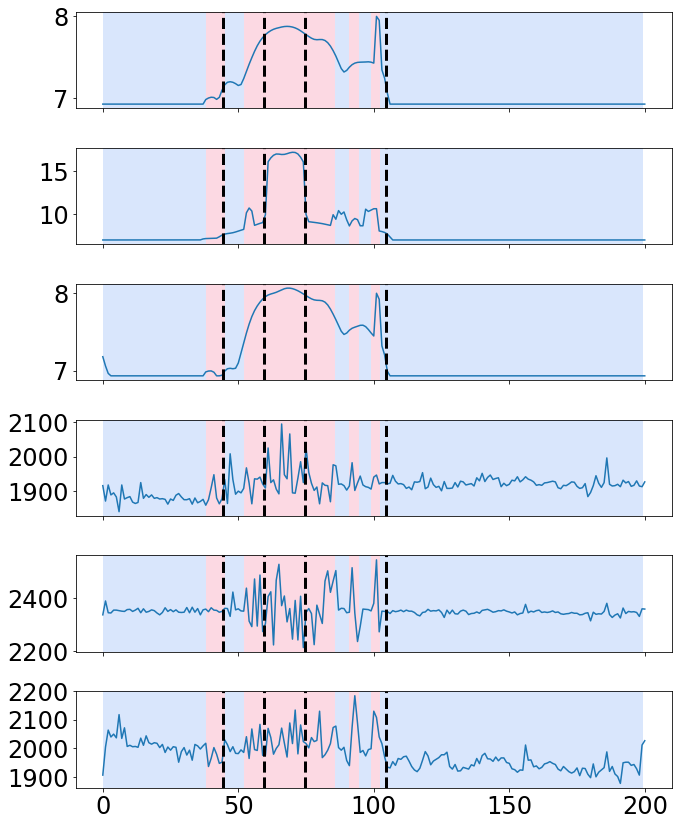

In [66]:
# display
rpt.display(catted, change_points/gpr_subsample_rate, gpr_result)
plt.show()